In [26]:
%matplotlib inline

import os
import re
import glob
import math
import shutil
import pandas as pd
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt

DEBUG = False

In [27]:
# input sample paths
# the order is importent
BASE_PATHS = [
    '../example_2',
    '../example_1'
]

MAIN_NAME = 'example_2'

# input paths inside of an each sample path
INPUT_RESULT_FOLDER = 'output/finder'
INPUT_PROFILES_FOLDER = 'output/generator/profiles/cropped'

# output folder - will include figures
OUTPUT_FIGURES_FOLDER = '../figures'

# output file extension == image format
OUTPUT_IMAGE_EXTENSION = 'svg' # jpg

In [28]:
def clean_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
    
clean_folder(OUTPUT_FIGURES_FOLDER)

In [29]:
paths = BASE_PATHS
names = list(map(lambda p: os.path.basename(p), paths))
if not (('MAIN_NAME' in locals() or 'MAIN_NAME' in globals()) and len(MAIN_NAME) > 0): 
    MAIN_NAME = names[-1] # todo
    
if MAIN_NAME in names:
    main_id = names.index(MAIN_NAME)
else:
    main_id = len(names) - 1
    MAIN_NAME = names[main_id]

paths.insert(0, paths.pop(main_id))
names.insert(0, names.pop(main_id))
main_id = 0

In [30]:
if DEBUG:
    print(MAIN_NAME)

In [31]:
samples = []

for path in paths:

    # results
    results_file = glob.glob(os.path.join(path, INPUT_RESULT_FOLDER, '*.csv'))
    if len(results_file) == 0:
        break
    res = pd.read_csv(results_file[0], encoding='utf-8', sep=',', skipinitialspace=True)
    id_list = res.profile_id
    
    # profiles
    profiles_folder = os.path.join(path, INPUT_PROFILES_FOLDER, '*.csv')
    transect_files = natsorted(glob.glob(profiles_folder))
    transects = pd.DataFrame()
    transect_names = []

    for name in transect_files:
        transect_names.append(name)
        transects = pd.concat([transects, pd.read_csv(name, encoding='utf-8', sep=',', skipinitialspace=True)])
    
    samples.append({
        'results': res,
        'profiles': transects,
        'profile_names': list(map(lambda p: os.path.basename(p), transect_names))
    })

In [32]:
if DEBUG:
    print(samples[1]['profiles'].loc[samples[1]['profiles']['no_transect'] == 1 ])

In [33]:
def get_distance(ax, ay, bx, by):
    return ((ax - bx)**2 + (ay - by)**2) ** 0.5

def project_points(transect_csv, subpoints):
    subpoints_idx = []
    for subpoint in subpoints:

        dist1 = float('inf')
        dist2 = float('inf')
        for point in transect_csv.loc[:, ['x_geo', 'y_geo', 'no_point']].values:
            d1 = get_distance(point[0], point[1], subpoint[1], subpoint[2])
            d2 = get_distance(point[0], point[1], subpoint[3], subpoint[4])
            if d1 < dist1:
                dist1 = d1
                idx1 = point[2]
            if d2 < dist2:
                dist2 = d2
                idx2 = point[2]                
        
        subpoints_idx.append([min([idx1, idx2]), max([idx1, idx2])])

    return subpoints_idx

In [34]:
def draw_profile_features(title, axlines, points, profiles, names, begin_no, end_no, main_id, zoom=False, save=False, show=True, link=False):

    def plot_point(profile, point, base, color, mark, is_main):
        if math.isnan(point):
            return

        point = point.astype(int)
        if point < len(y) and point > 0:
            # point
            plt.plot(point, y[point], f'{mark}', color=color, markersize=10 if is_main else 6)
            
            if is_main:
                # line
                l = max(y) / 4
                yy = y[point] + (max((l, 4)) * base/abs(base)) # + label_y
                plt.plot((point, point), (y[point], yy), '--', color=color)

                # label
                plt.annotate(f'{point}: {profile.elevation[point]:.2f}m', (point, yy))
    
    aux = []
    
    x_min = len(profiles[main_id]) + 1
    x_max = 0
    y_min = max(profiles[main_id].elevation)
    y_max = 0
    
    for profile in profiles:
        first_no = float('nan')
        last_no = float('nan')
        cut = profile[profile['index_right'] >= 0]
        if len(cut) > 0:
            first_no = cut.iloc[0]['no_point']
            last_no = cut.iloc[-1]['no_point'] + 1
            first_no = first_no if first_no > begin_no else begin_no
            last_no = last_no if last_no < end_no else end_no

            _x_min = begin_no if not zoom else first_no - 10
            _x_max = end_no if not zoom else last_no + 10
            _y_min = min(profile.elevation)
            _y_max = max(profile.elevation)
            
            x_min = _x_min if _x_min < x_min else x_min
            x_max = _x_max if _x_max > x_max else x_max
            y_min = _y_min if _y_min < y_min else y_min
            y_max = _y_max if _y_max > y_max else y_max           
            
        aux.append({
            'cut': cut,
            'first_no': first_no,
            'last_no': last_no,
            'profiles': profile
        })

    plt.xlim((x_min, x_max))
    plt.ylim((y_min - 1, y_max + 10))
    plt.gca().set_aspect('equal')
    plt.title(f'{title}  {"[zoomed]" if zoom else ""}')
    plt.xlabel('point no')
    plt.grid(linestyle=':')

    if len(list(filter(lambda d: d['first_no'] == d['first_no'], aux))) > 0:

        for line in axlines:
            plt.axhline(y = line, color = 'y', linestyle = '--')

        if link:
            point1 = [aux[main_id]['cut'].iloc[0]['no_point'], profiles[main_id].elevation[aux[main_id]['cut'].iloc[0]['no_point']]]
            point2 = [aux[main_id]['cut'].iloc[-1]['no_point'], profiles[main_id].elevation[aux[main_id]['cut'].iloc[-1]['no_point']]]
            x_values = [point1[0], point2[0]]
            y_values = [point1[1], point2[1]]
            plt.plot(x_values, y_values, 'r', linestyle="dotted")

        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        for idx, profile in enumerate(profiles):
            is_main = idx == main_id
            
            zero_point = points[idx]['last_zero'].iloc[0]
            bottom_point = points[idx]['bottom'].iloc[0]
            top_point = points[idx]['top'].iloc[0]
            
            if aux[idx]['first_no'] == aux[idx]['first_no']:
                y = profile['elevation'][begin_no:end_no].to_numpy()
                plt.plot(np.arange(begin_no, end_no), y, '--', color=colors[idx], linewidth=2 if is_main else 1)            

                x1 = np.arange(aux[idx]['first_no'], aux[idx]['last_no'])
                y1 = profile['elevation'][aux[idx]['first_no']:aux[idx]['last_no']].to_numpy()
                label = names[idx] if not bottom_point == bottom_point and not top_point == top_point else f'{names[idx]} ({zero_point:.0f}, {bottom_point:.0f}, {top_point:.0f})'
                plt.plot(x1, y1, color=colors[idx], linewidth=2 if is_main else 1, label=label)

                if is_main:
#                     plt.fill_between(x1, 0, y1, alpha=0.2, color=colors[idx])
                    plt.fill_between(x1, 0, y1, alpha=0.1, color=colors[idx], hatch="...")

            if len(points[idx]) > 0:
                plot_point(profile, zero_point, base=2, color=colors[idx], mark='o', is_main=is_main)
                plot_point(profile, bottom_point, base=2, color=colors[idx], mark='v', is_main=is_main)
                plot_point(profile, top_point, base=2, color=colors[idx], mark='^', is_main=is_main)

            plt.legend()

            if save:
                file_to_save = os.path.join(OUTPUT_FIGURES_FOLDER, f'{title}.cut{".zoom" if zoom else ""}.{OUTPUT_IMAGE_EXTENSION}')
                plt.savefig(file_to_save, bbox_inches='tight', pad_inches=1, dpi=300)

    if show:
        plt.show()      

    plt.close()

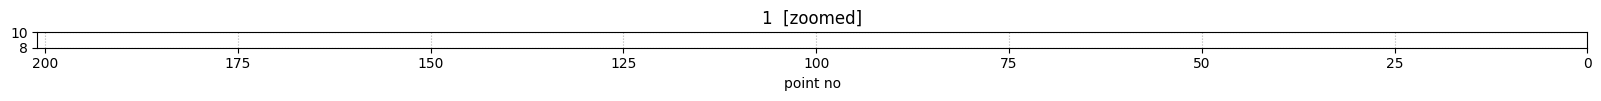

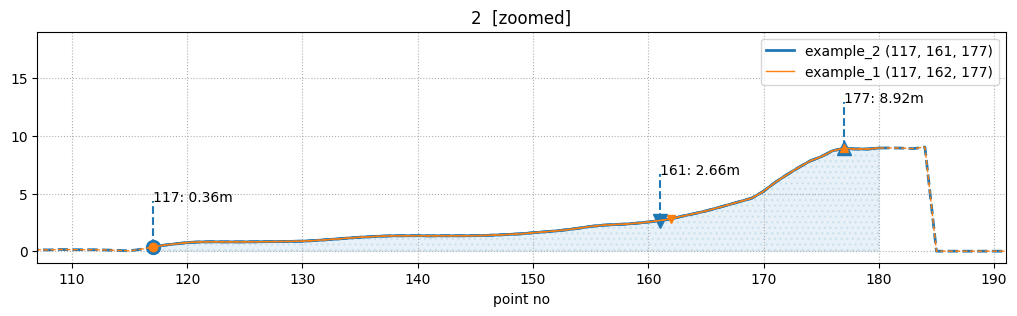

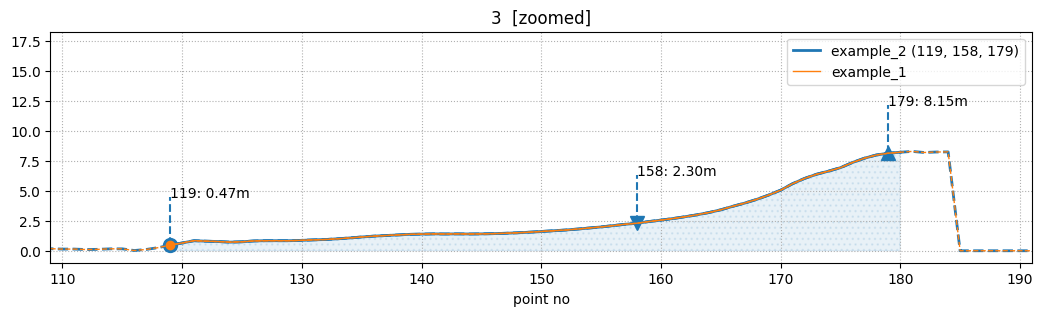

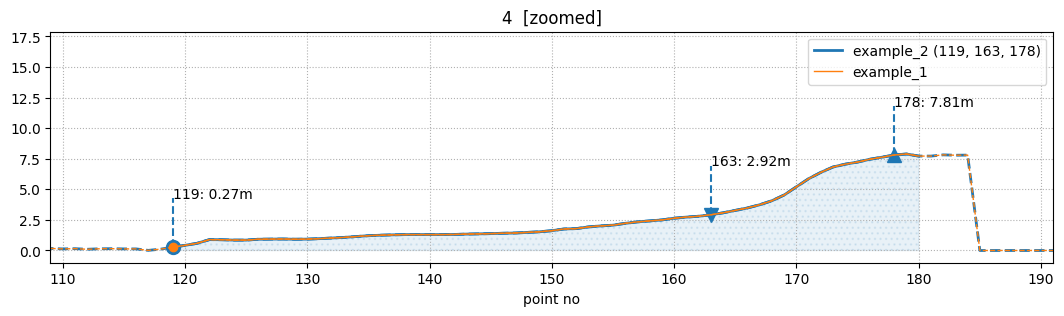

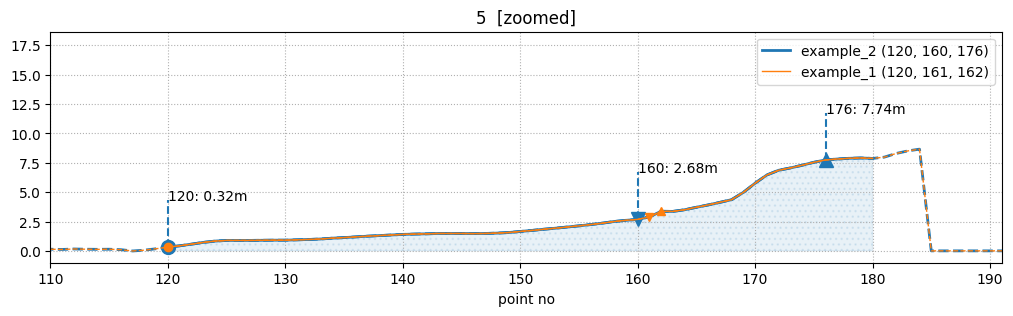

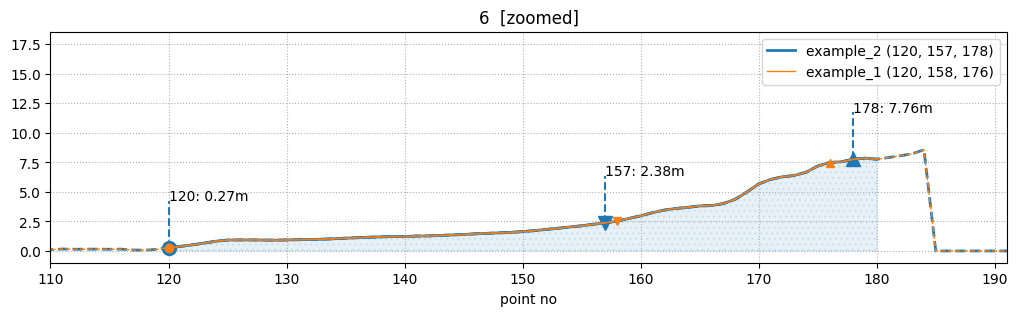

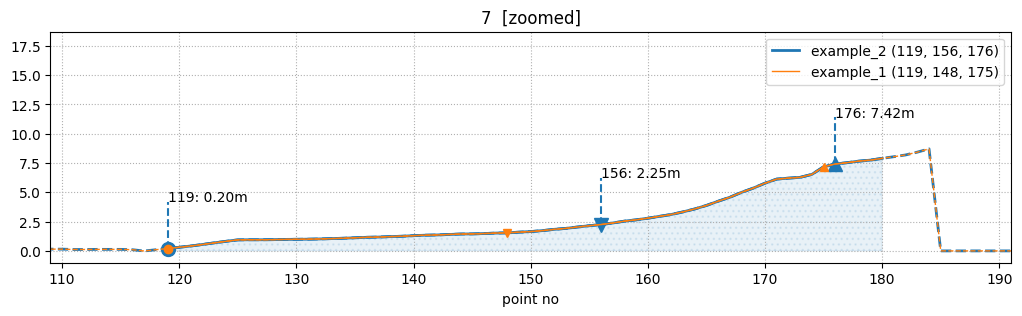

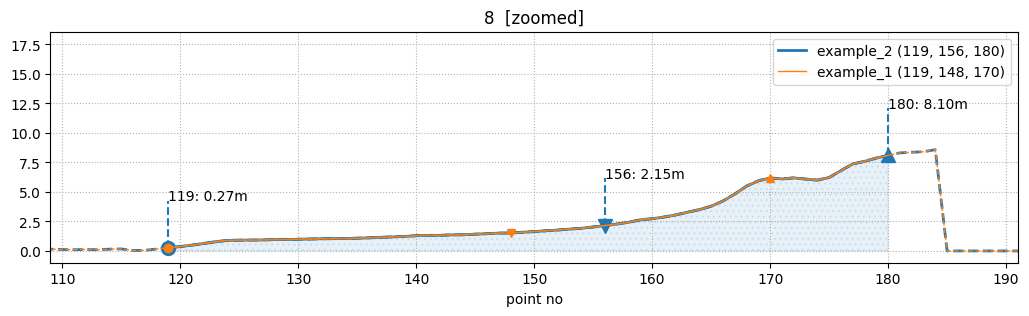

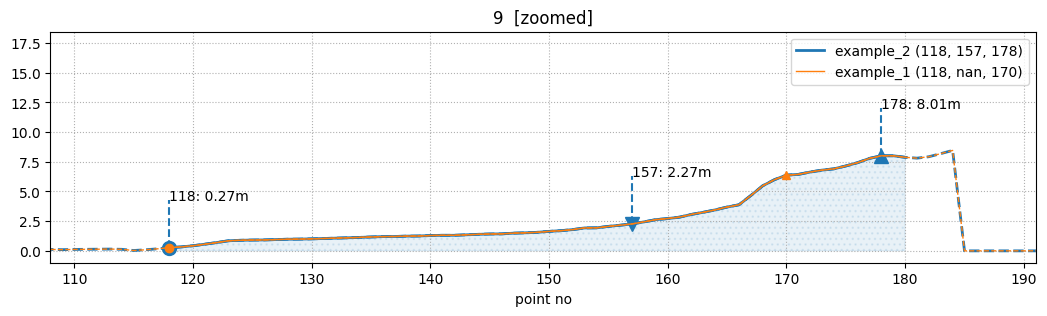

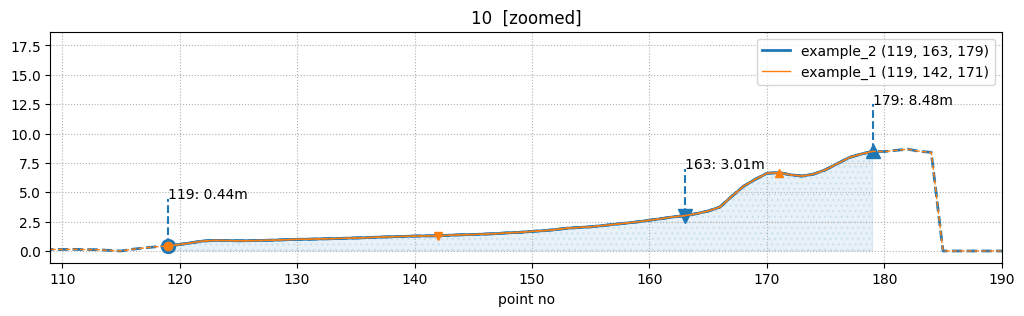

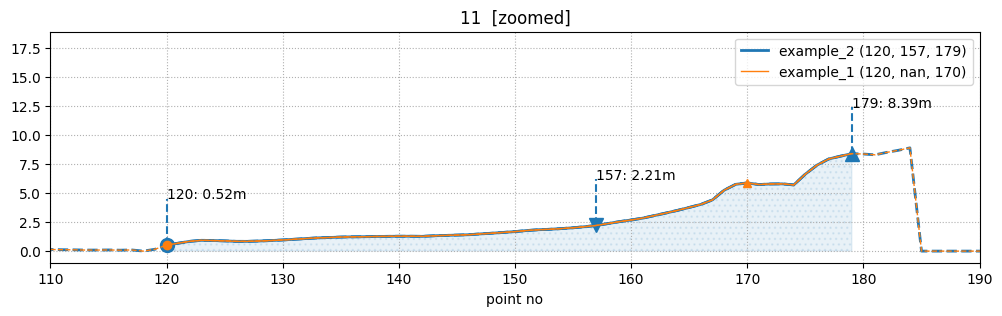

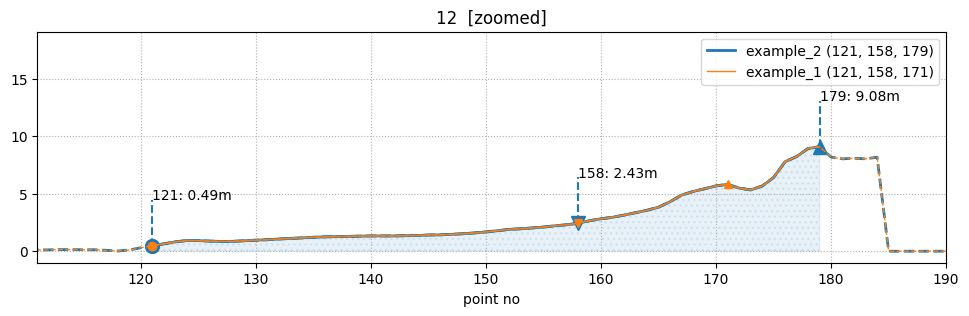

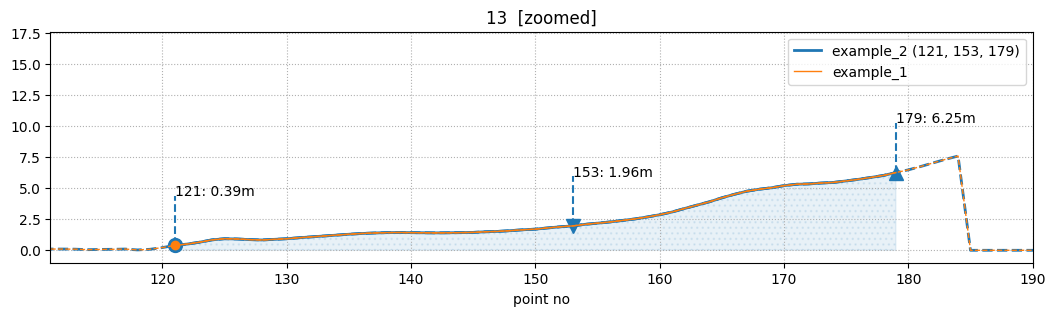

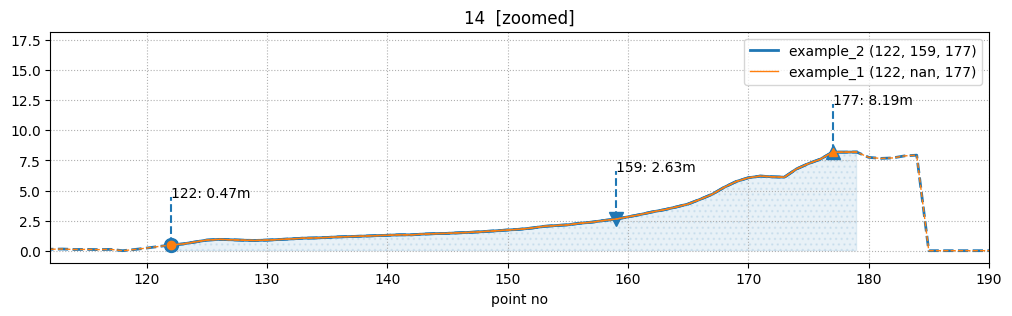

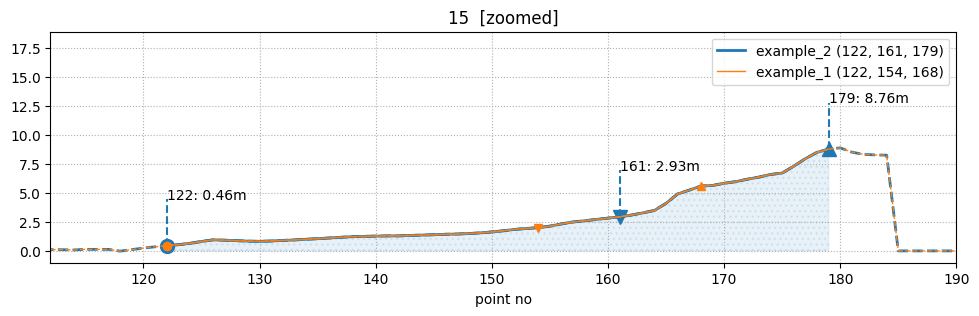

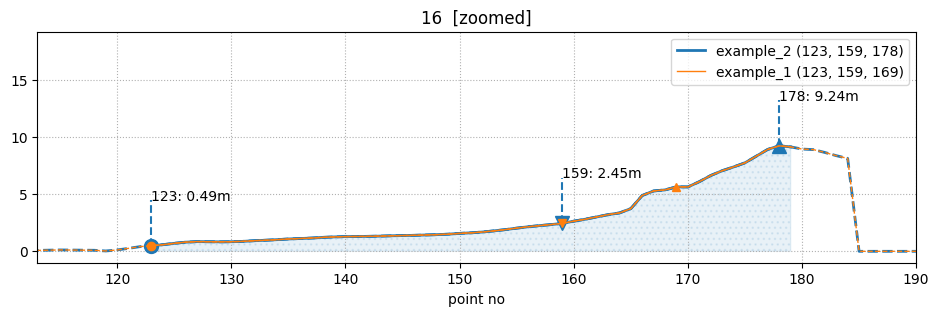

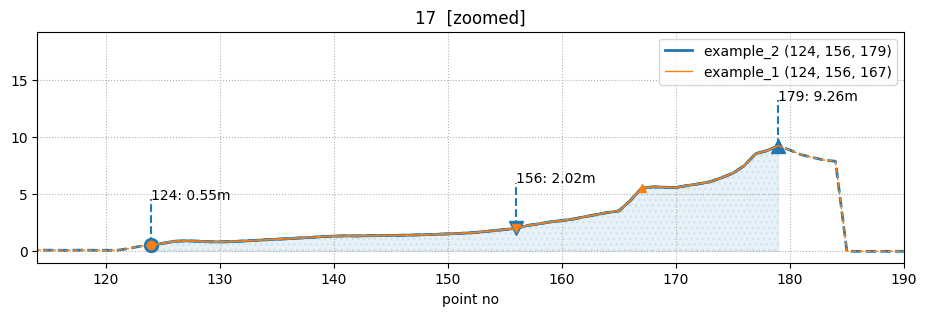

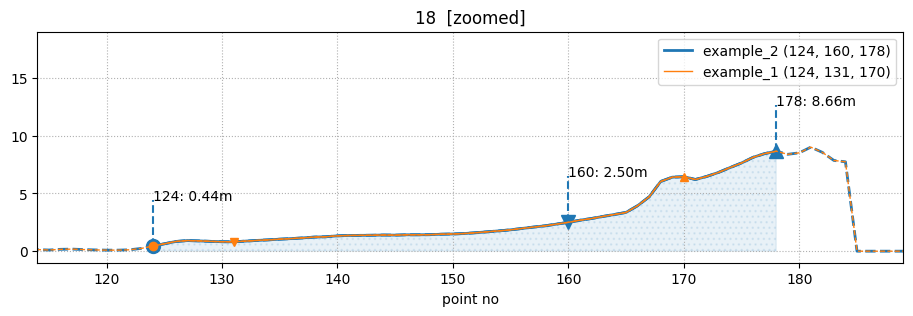

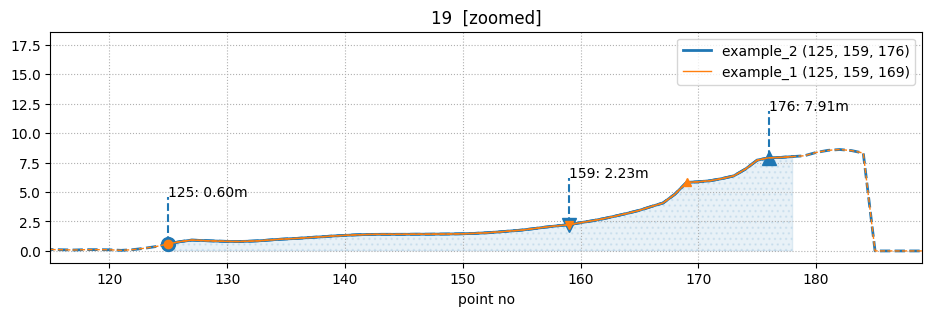

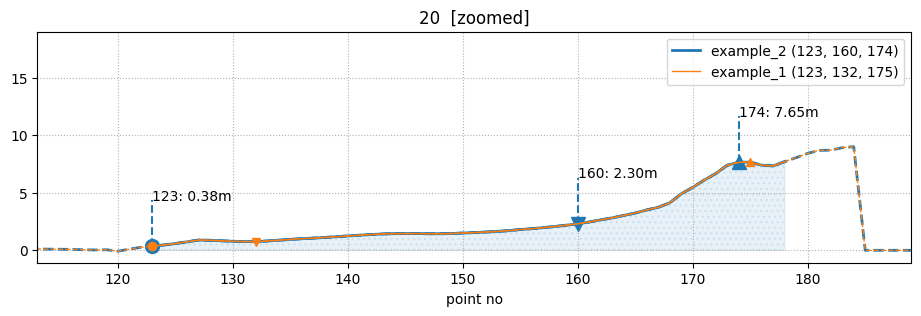

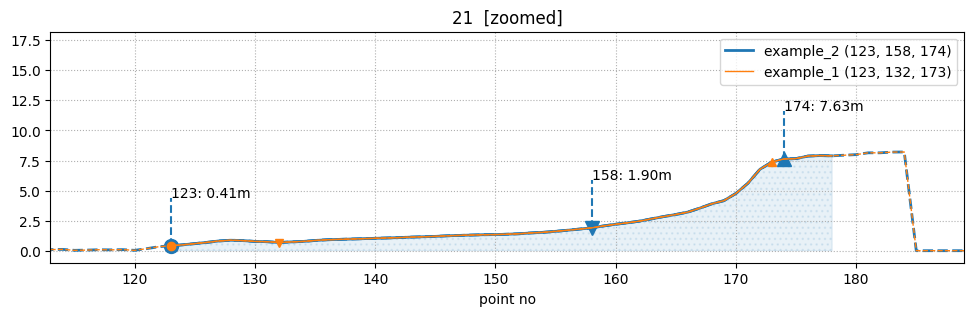

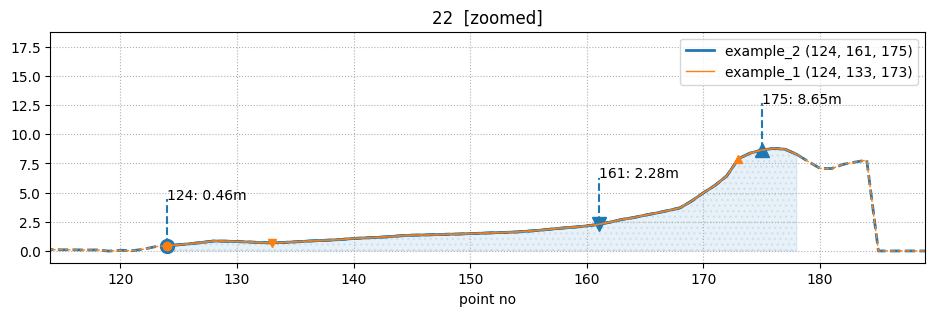

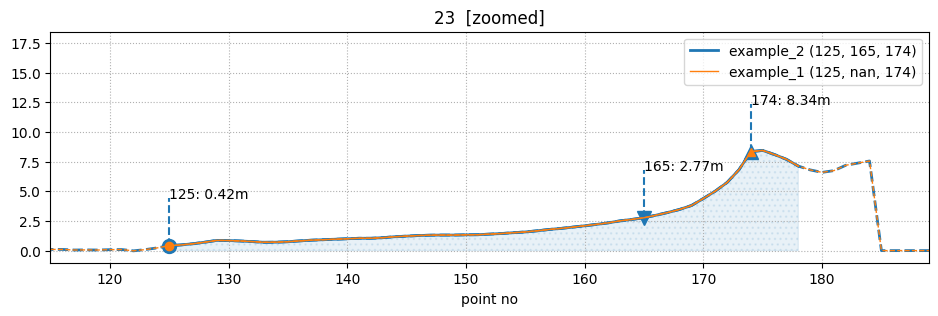

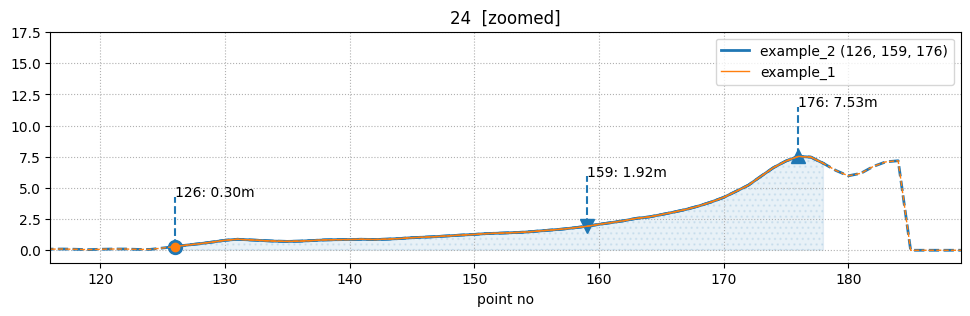

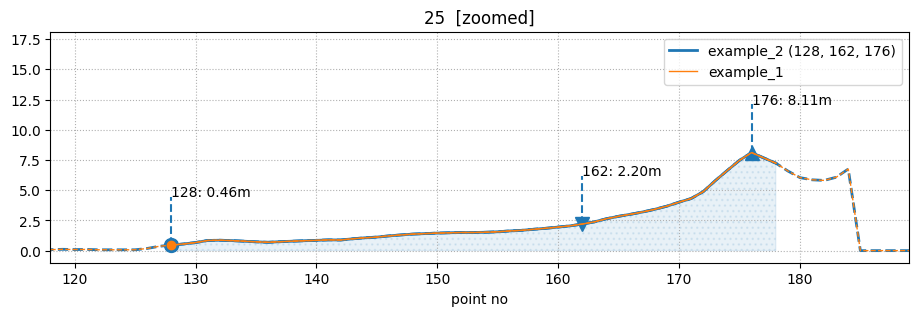

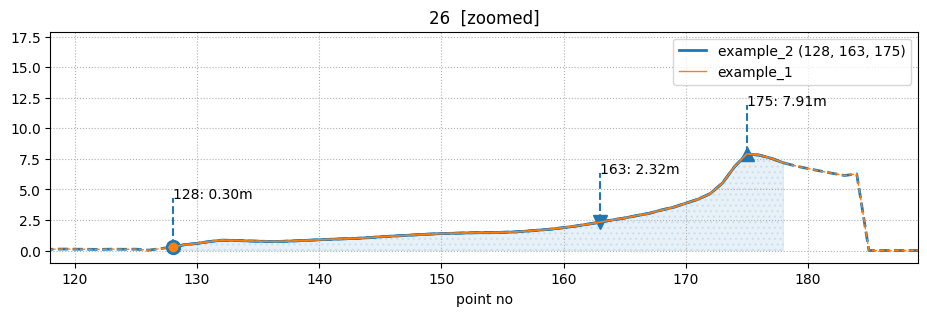

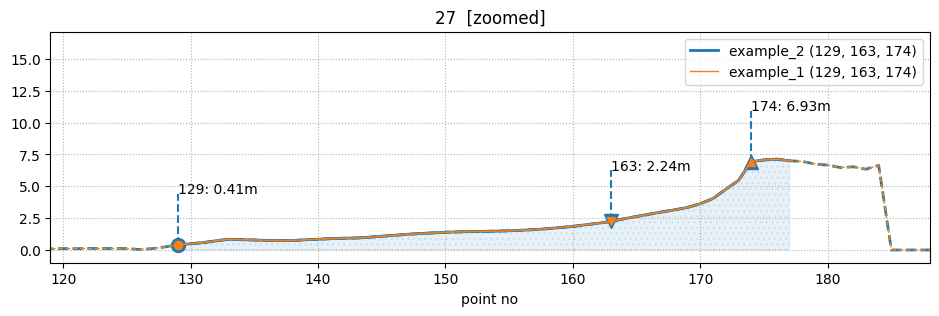

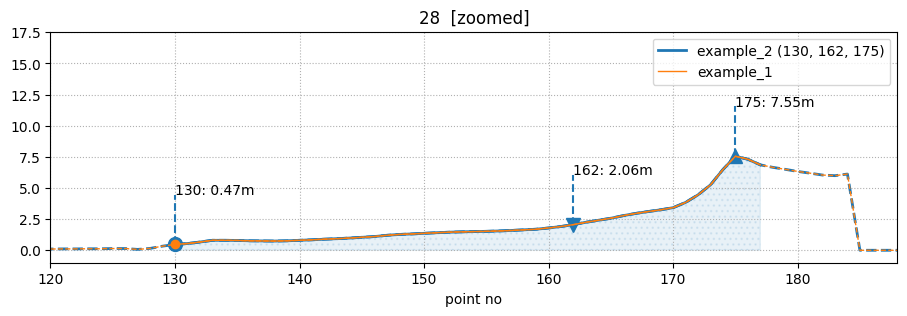

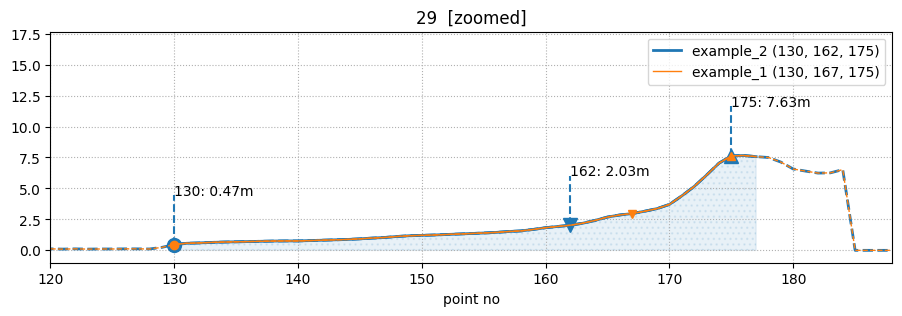

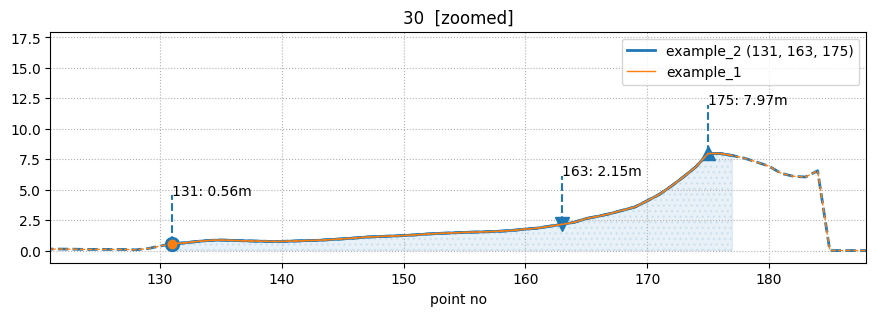

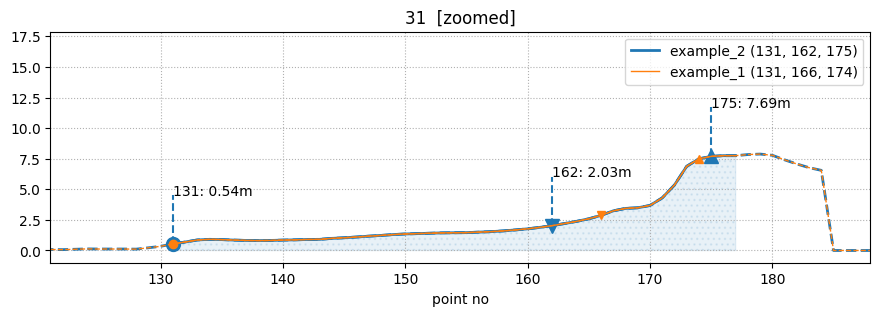

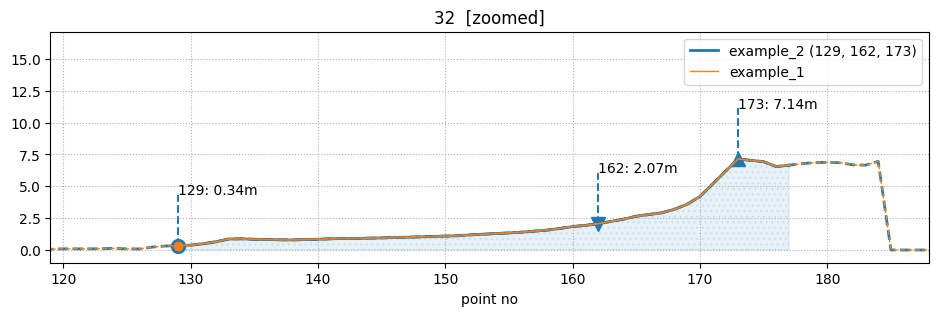

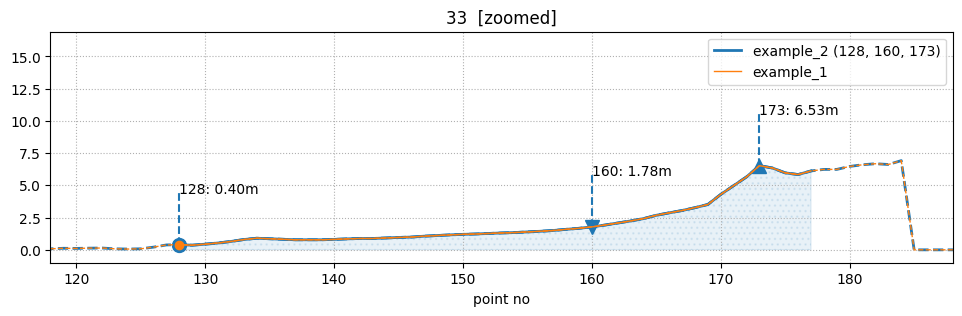

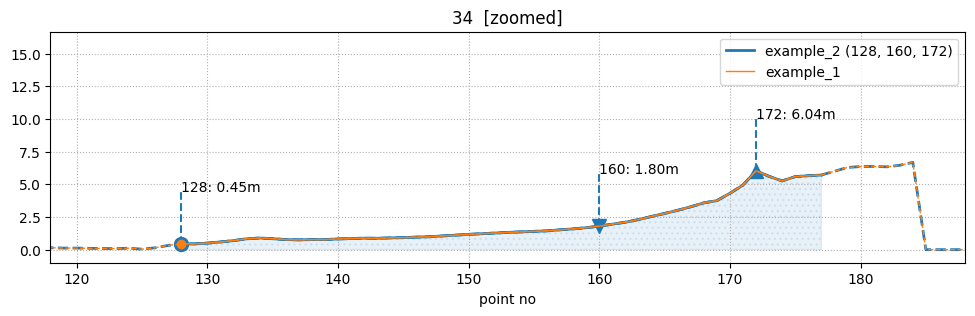

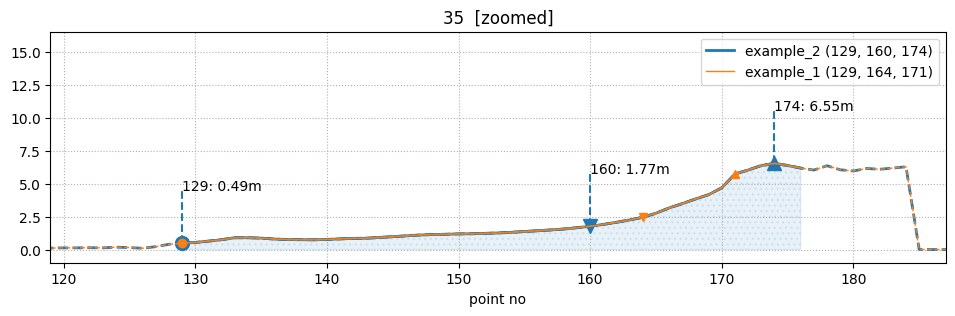

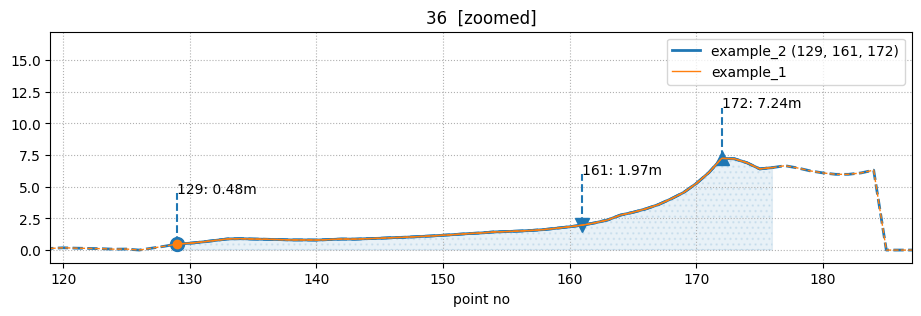

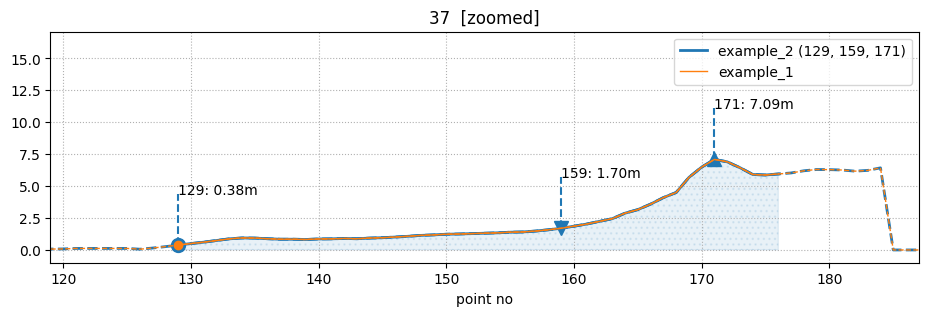

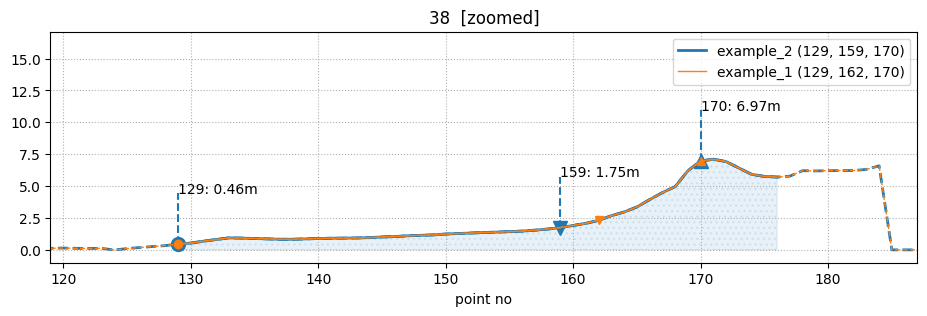

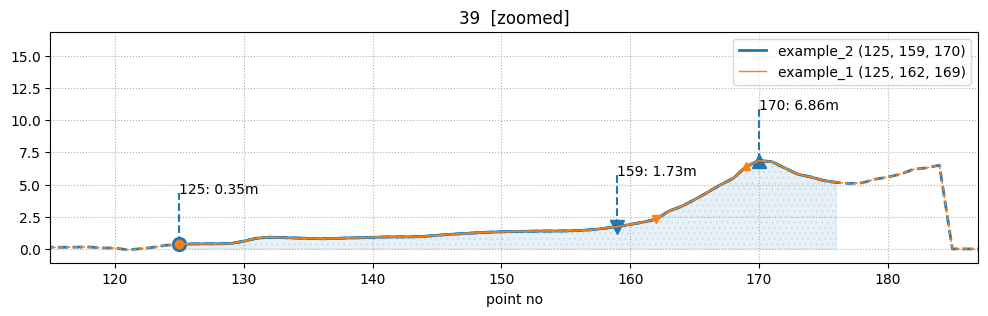

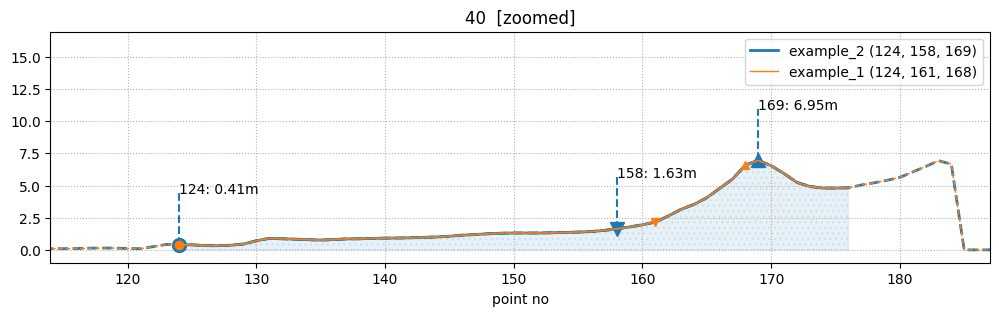

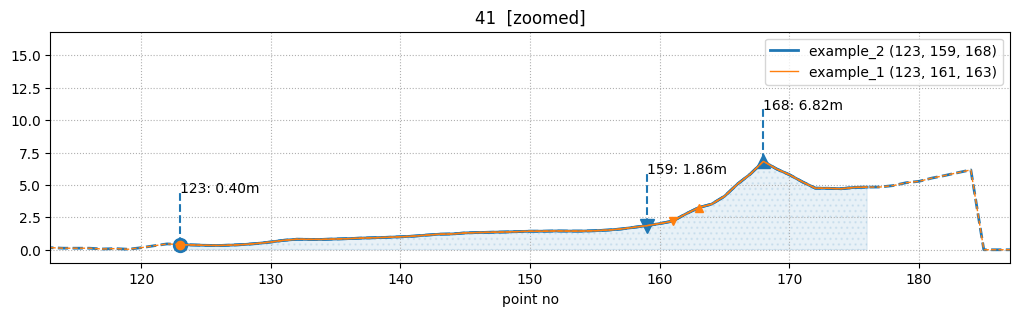

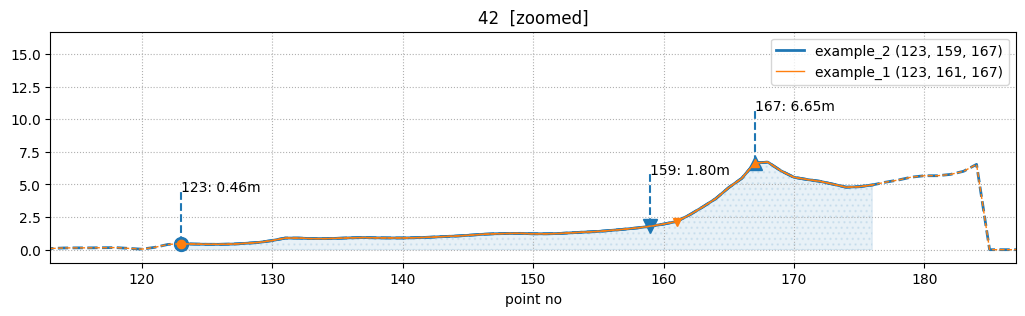

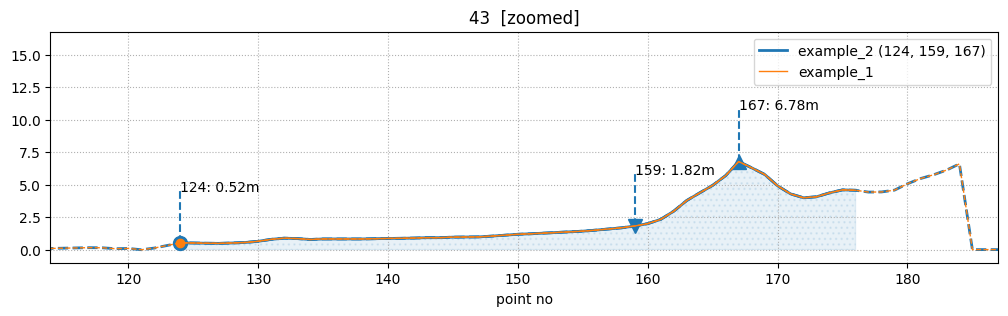

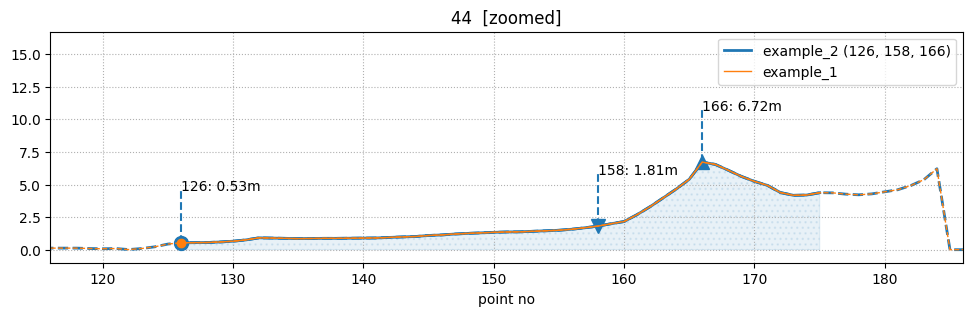

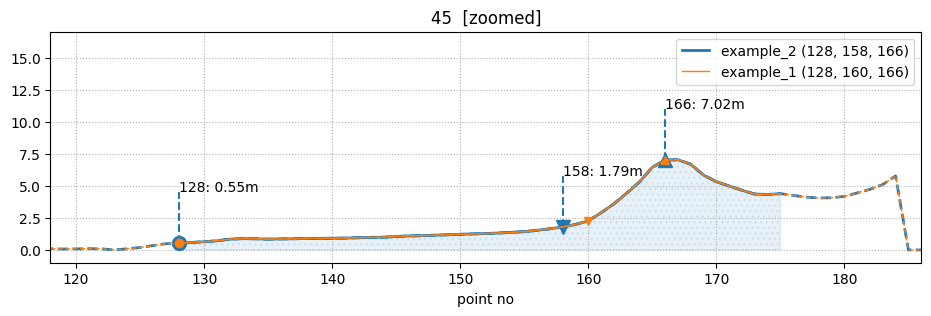

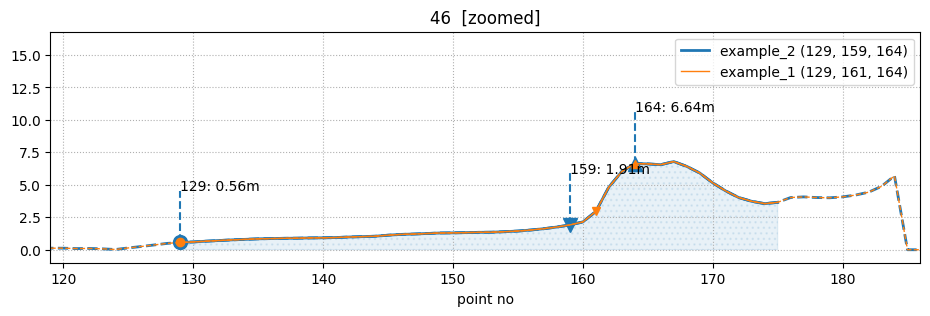

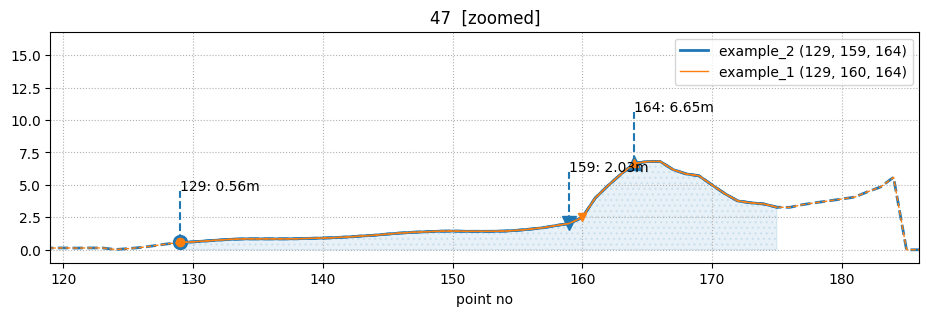

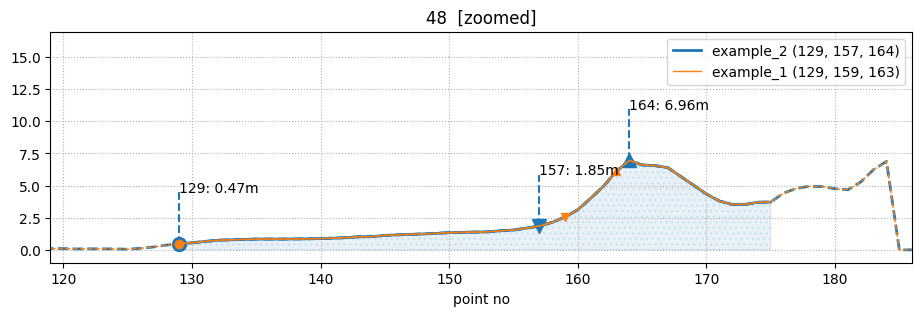

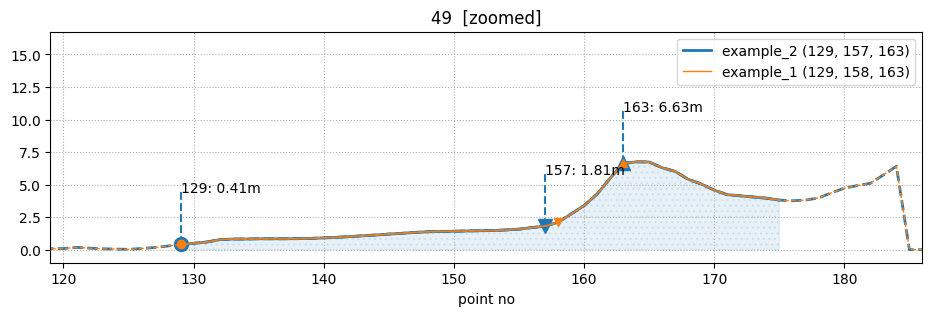

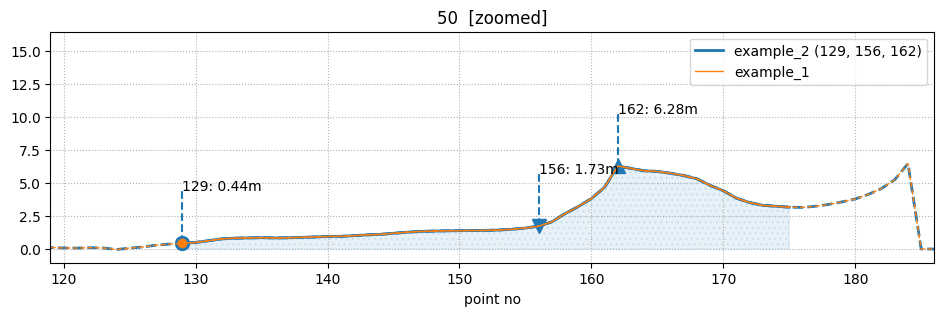

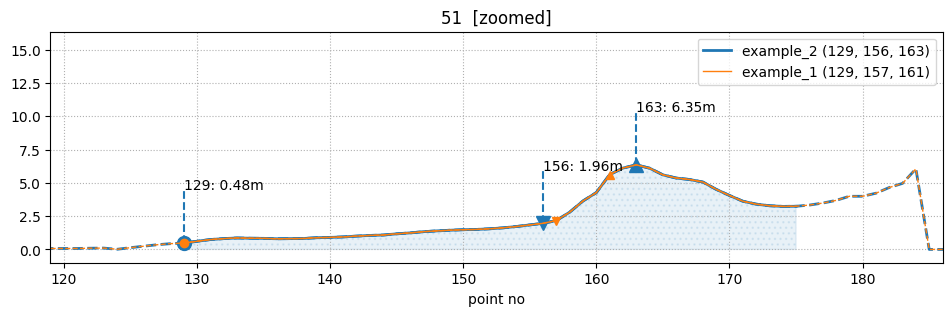

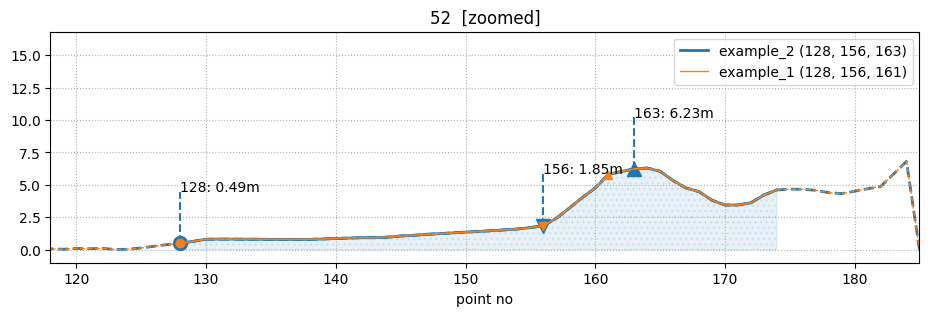

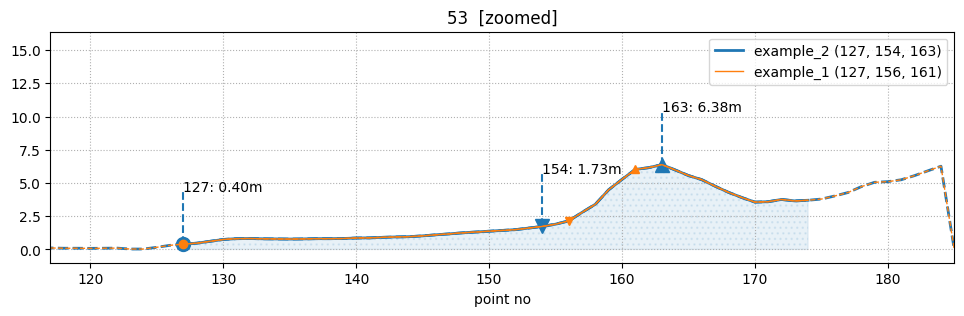

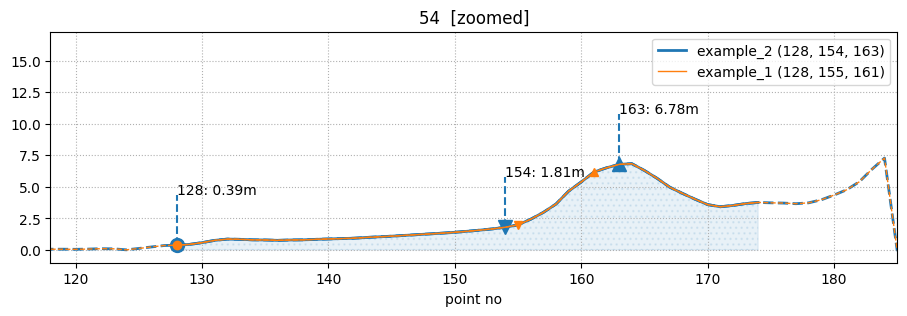

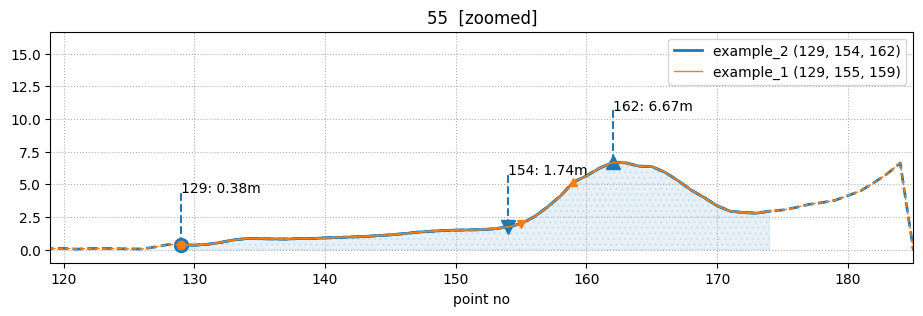

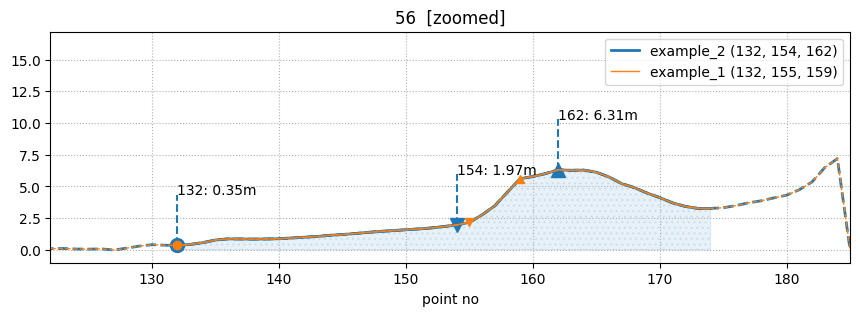

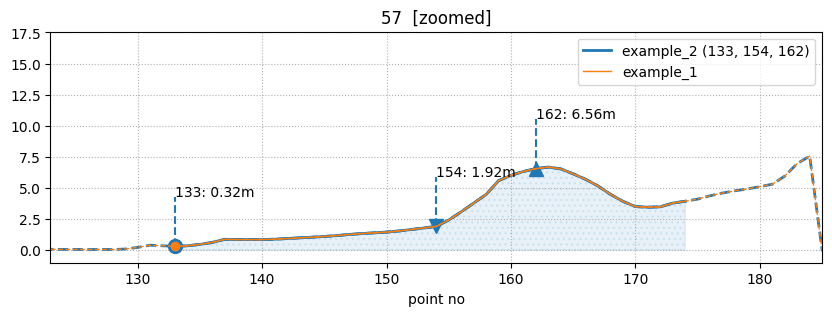

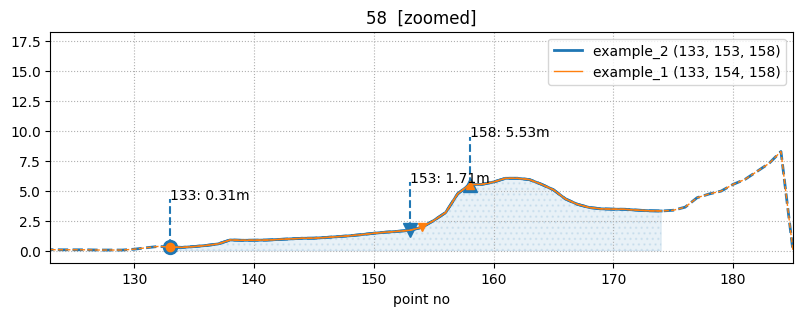

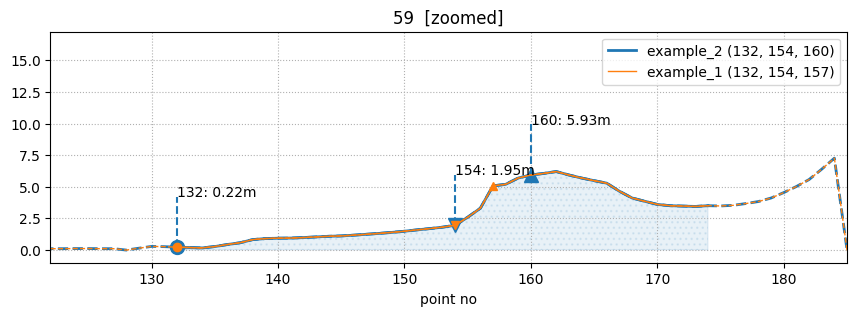

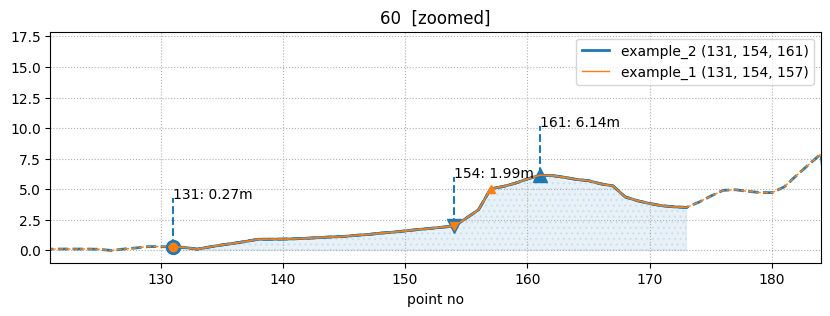

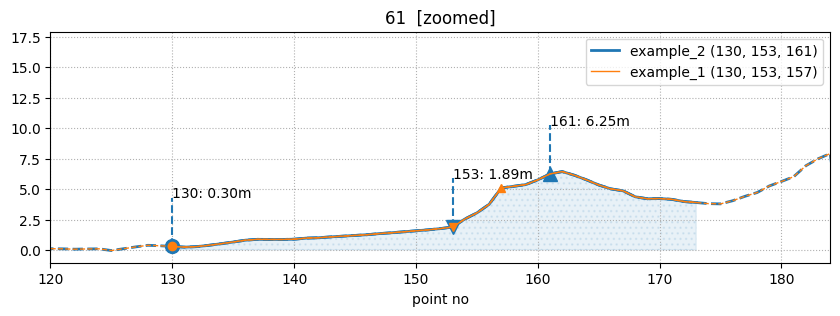

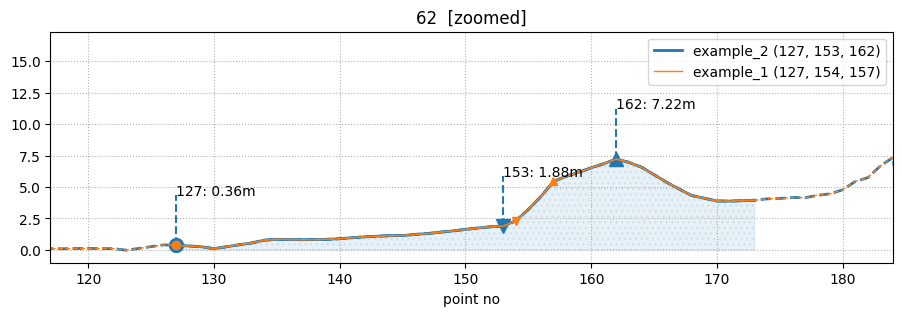

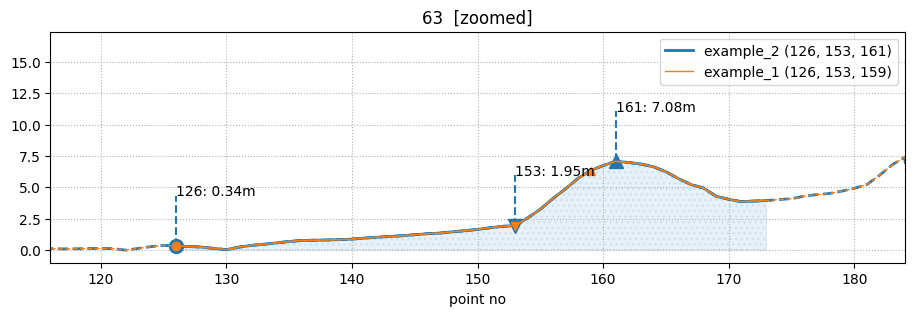

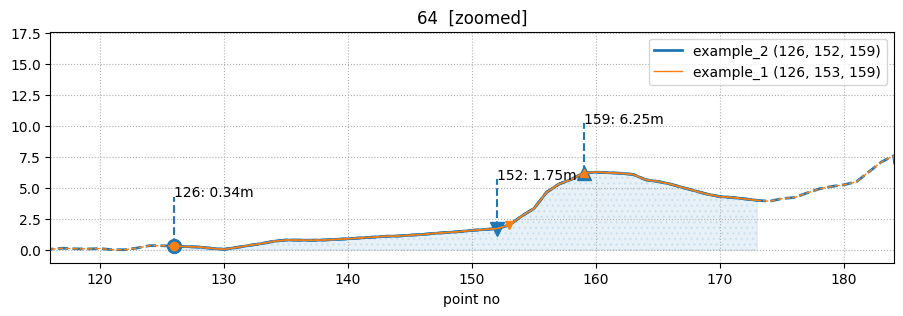

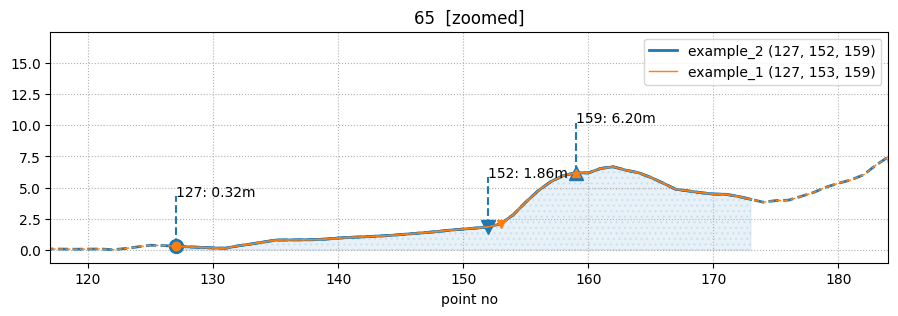

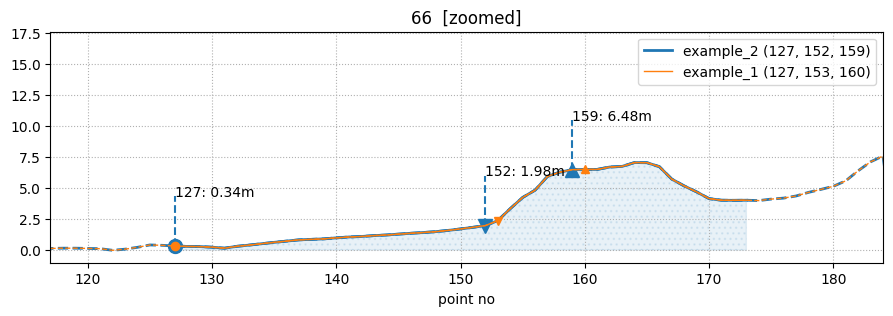

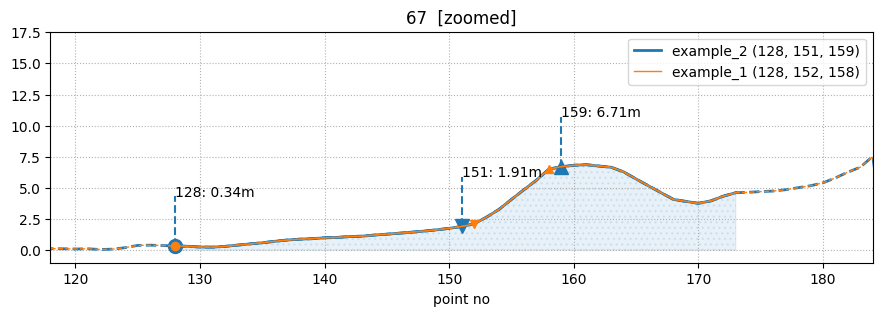

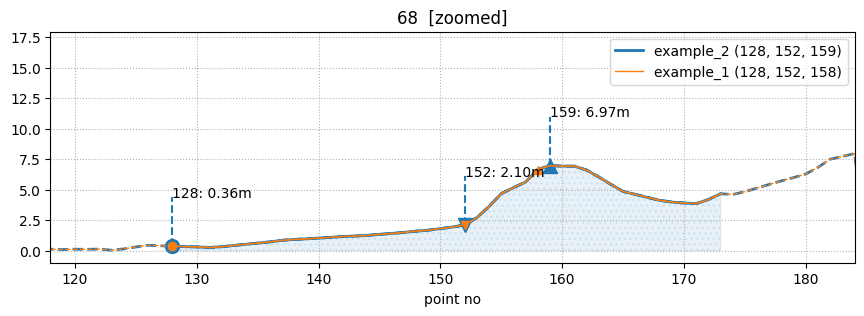

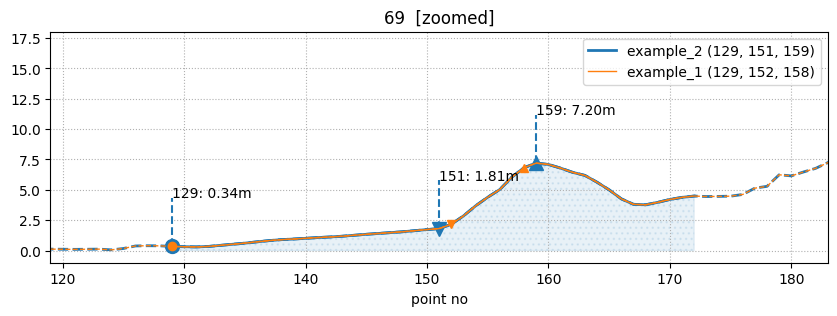

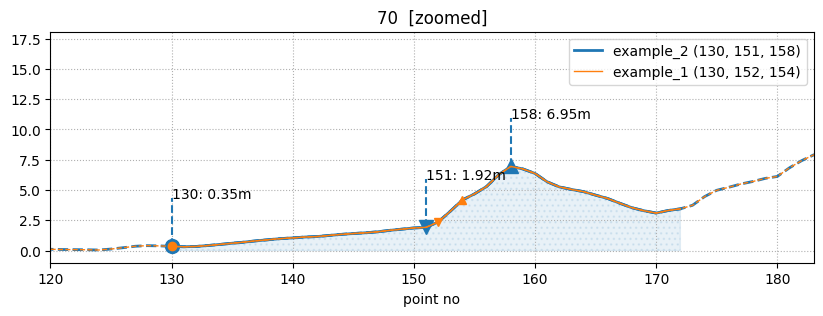

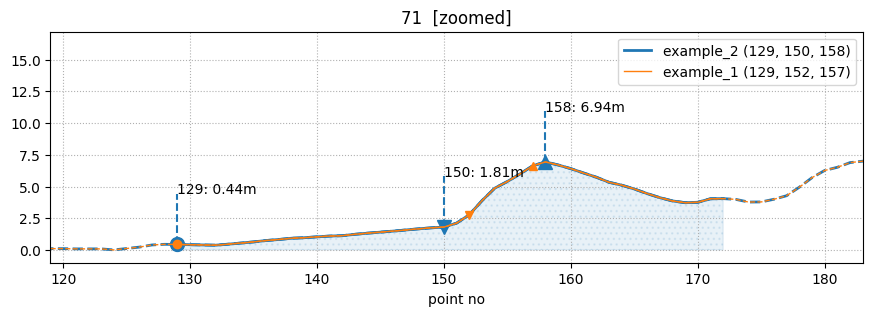

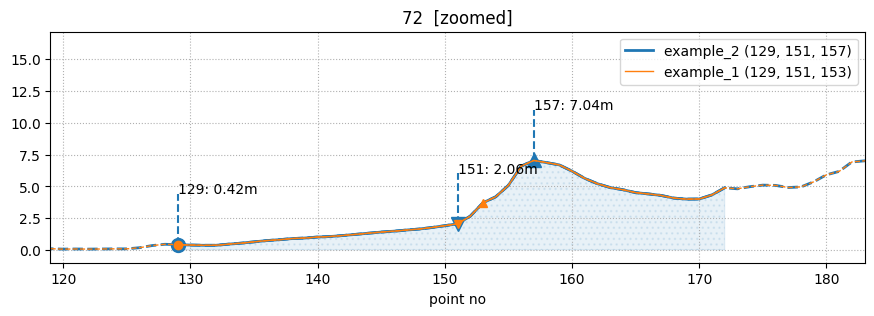

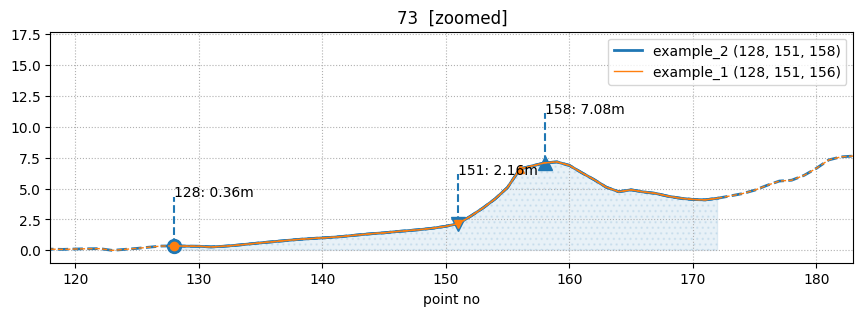

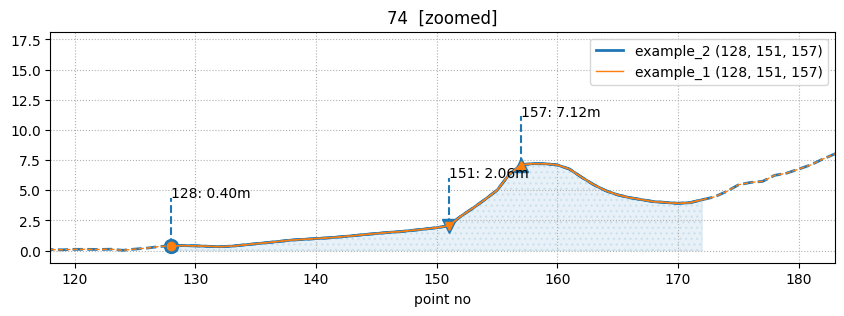

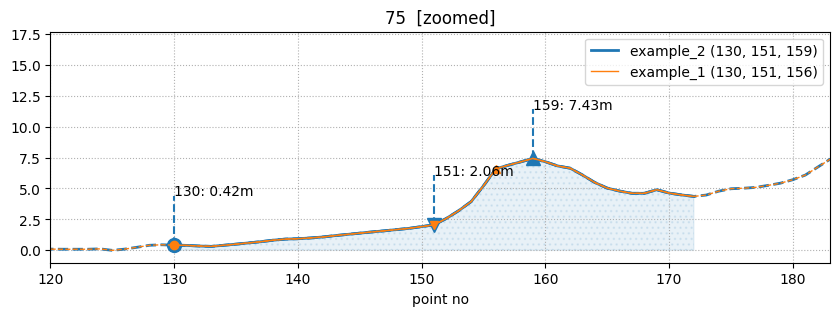

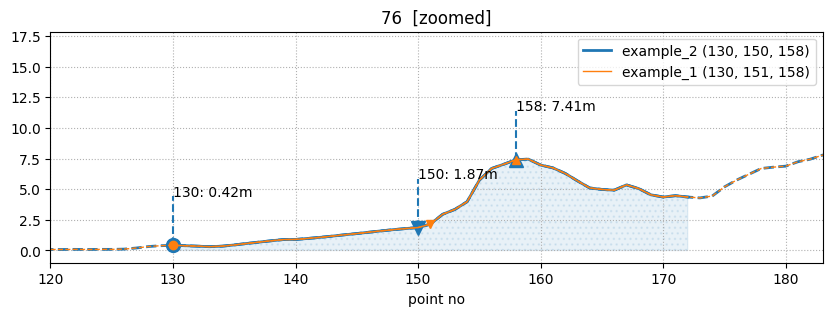

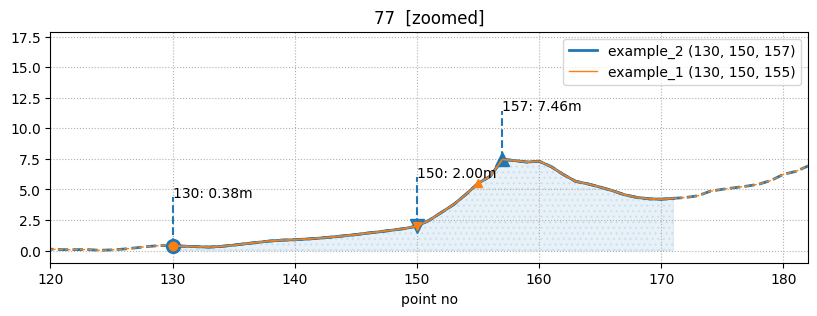

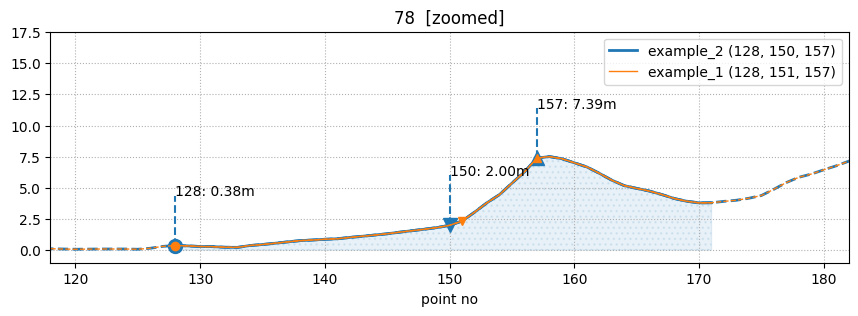

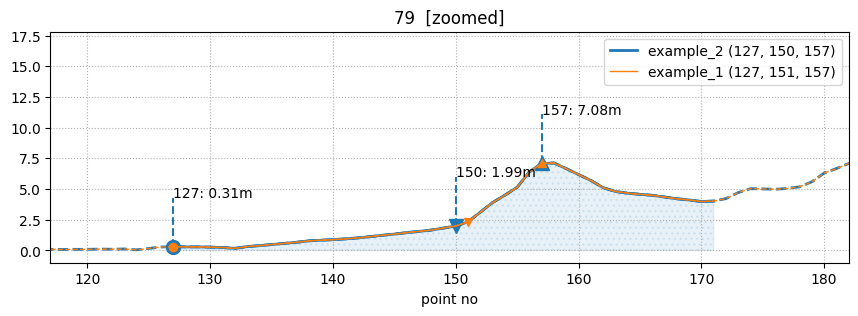

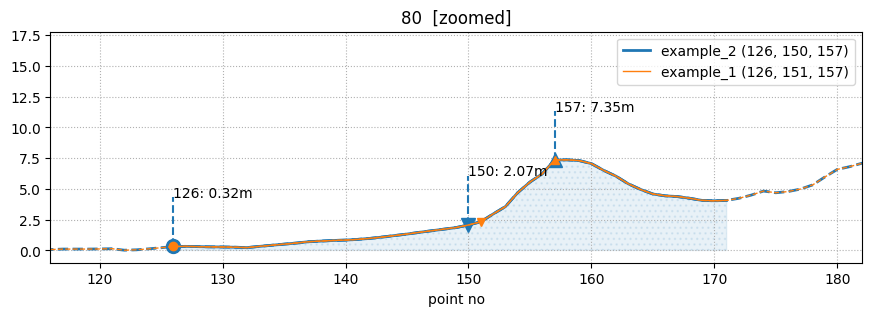

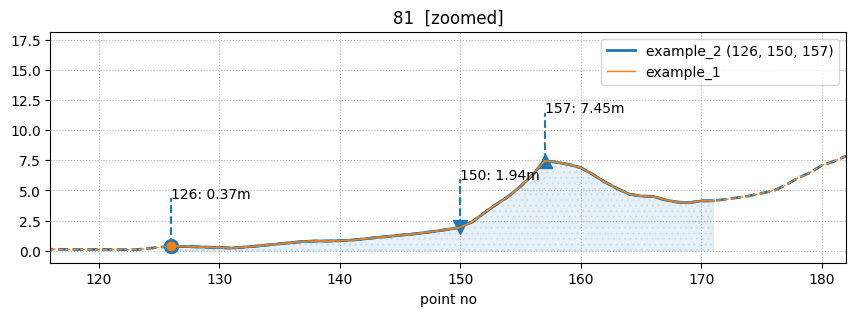

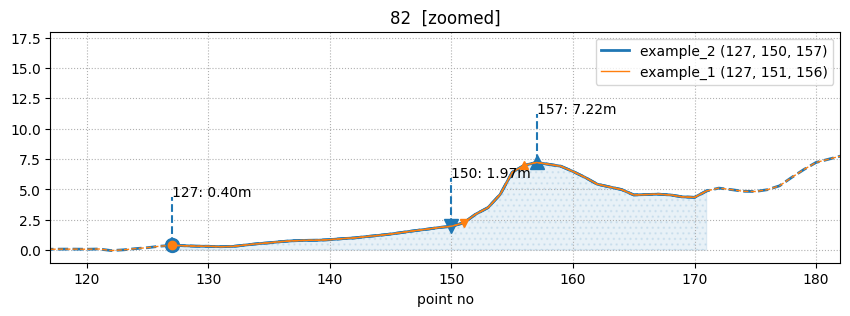

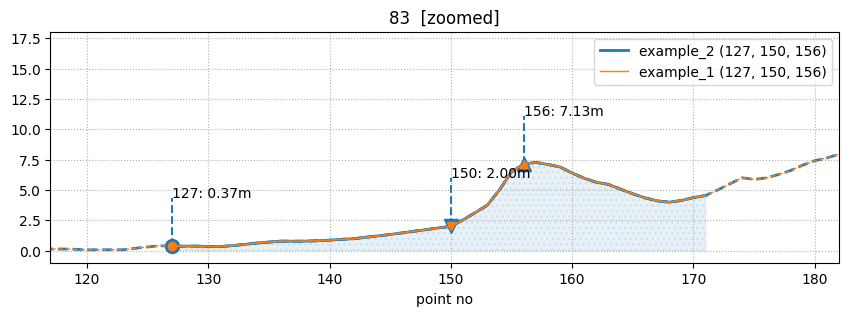

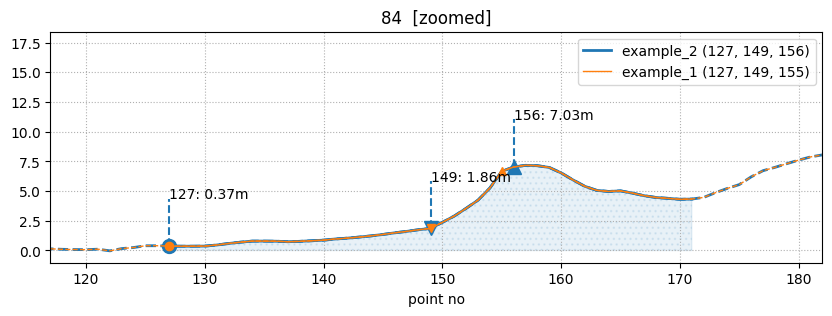

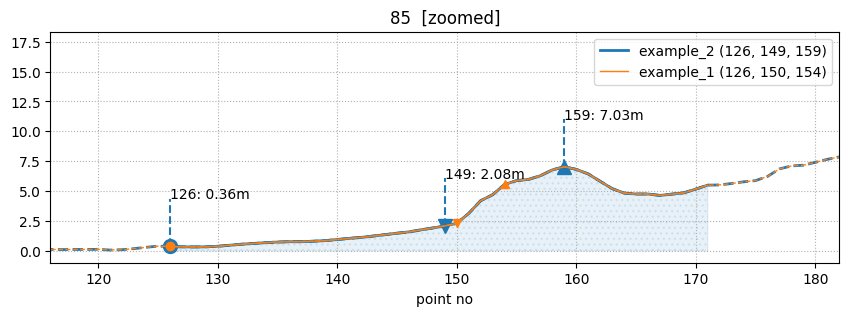

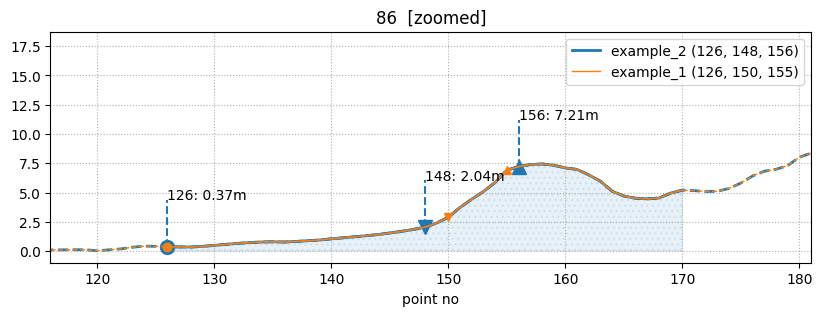

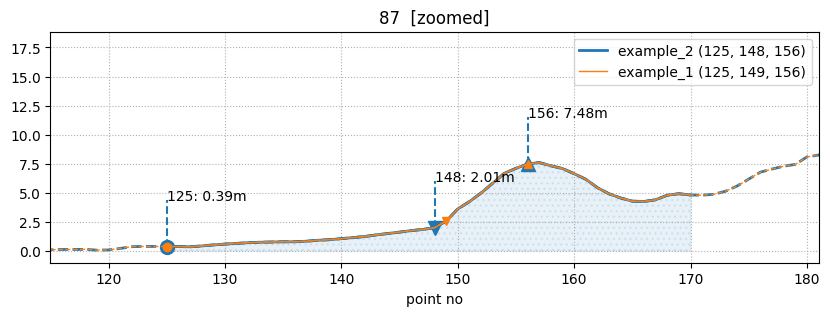

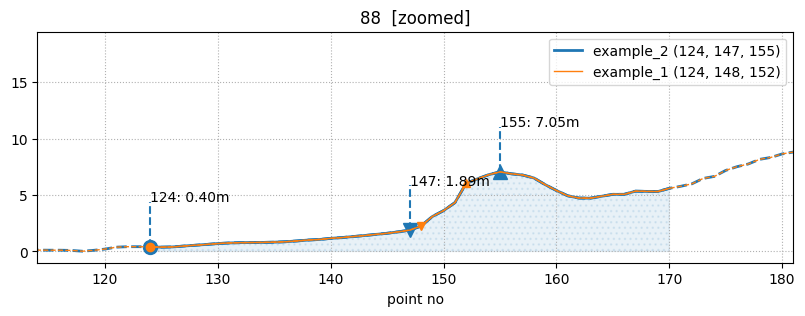

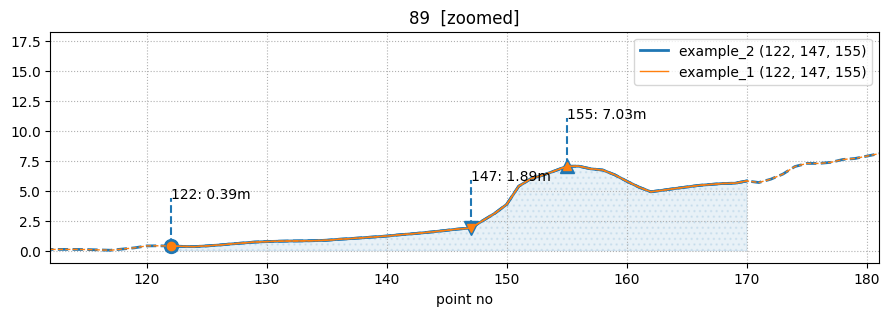

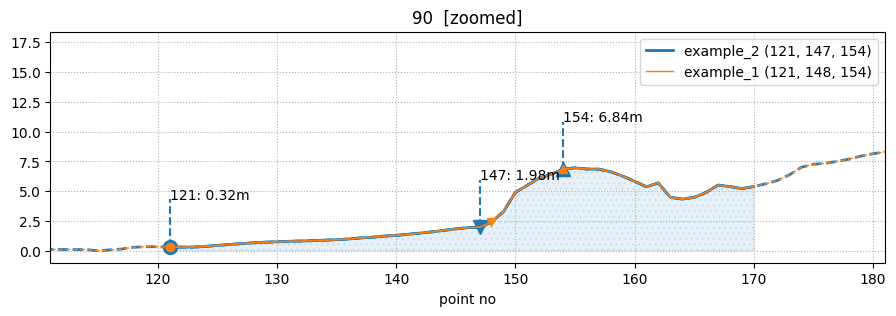

IndexError: list index out of range

In [35]:
plt.rcParams["figure.figsize"] = (20, 3)

# --------------- all profiles -------------------------------------
profile_by_original_id = False
profiles_no_list = list(range(len(samples[main_id]['profiles'])))
# --------------- selected profiles --------------------------------

# --------------- selected profiles --------------------------------
# profile_by_original_id = True
# profiles_no_list = [108]
# profiles_no_list = [20, 30, 40]
# profiles_no_list = list(range(100, 303))
# --------------- selected profiles --------------------------------

# gen figuires 
for idx in profiles_no_list:
    
    if profile_by_original_id:
        profile_id = idx
    else:
        profile_id = int(re.findall('\d{1,4}', samples[main_id]['profile_names'][idx])[0])
    
    points = []
    profiles = []
    for sample in samples:
        points.append(sample['results'].loc[sample['results']['profile_id'] == profile_id])
        profiles.append(sample['profiles'].loc[samples[1]['profiles']['no_transect'] == profile_id])
    
    draw_profile_features(
        title=profile_id,
#         axlines=[0, 10],
        axlines=[],
        
        points=points,
        profiles=profiles,
        names=names,
        begin_no=0,
        end_no=len(profiles[main_id]) - 1,
        main_id=main_id,

        zoom=True,
        save=True,
        show=True
    )